<a href="https://colab.research.google.com/github/StuartLiv/CPSC-440-Project/blob/main/models/lab_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array # TODO don't use keras
from keras.utils import load_img
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import random

from google.colab import userdata

!pip install pytorch-msssim -q
from pytorch_msssim import ms_ssim

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [2]:

!pip install -q kornia
import kornia
import skimage


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 51.9 MB/s eta 0:00:00


# 1. Set up project in runtime
Create colab secrets for the following credentials for the repo to get runtime files and clone repo

In [3]:
!git config --global user.email {userdata.get('email')}
!git config --global user.name {userdata.get('name')}
!git clone https://{userdata.get('token')}@github.com/StuartLiv/CPSC-440-Project
%pwd

Cloning into 'CPSC-440-Project'...
remote: Enumerating objects: 166673, done.
remote: Counting objects: 100% (258/258), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 166673 (delta 141), reused 256 (delta 141), pack-reused 166415
Receiving objects: 100% (166673/166673), 831.92 MiB | 15.12 MiB/s, done.
Resolving deltas: 100% (37100/37100), done.
Updating files: 100% (249504/249504), done.


'/content'

# 2. Preprocess data

Datasets:
- `medset_multisize`
  - Single datasets. Dataset construction code in repo too
  - 12000 Images, in randomized order
  - Res 256x256 (grayscale images also available in 128x128, 64x64, 32x32)


Load datasets, partition sets, and make tensors in color-layer order for convolutions



In [ ]:
def make_image_arr(path,cut=None,end=False):

  def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

  files = os.listdir(path)
  files = sorted_alphanumeric(files)

  if end:
    files.reverse()
  if cut is not None:
    files = files[:cut]

  arr = []
  for i in tqdm(files):
    img = load_img(path + '/'+i)
    arr.append(img_to_array(img) / 255)

  return np.array(arr)

rgb_np = make_image_arr('/content/CPSC-440-Project/datasets/medset_multisize/color',cut=2400,end=True)
lab_np = skimage.color.rgb2lab(rgb_np)
color = torch.from_numpy(np.moveaxis(lab_np, [3,1], [1,2]))

def make_gray_tensor(path):
  graynp = make_image_arr(path,cut=2400,end=True)

  # take one axis
  graynp = np.moveaxis(graynp, [3,1], [1,2])

  # convert to LAB scale
  graynp = graynp[:, 0:1, :, :] * 100

  return torch.from_numpy(graynp)

gray032 = make_gray_tensor('/content/CPSC-440-Project/datasets/medset_multisize/gray32')
gray064 = make_gray_tensor('/content/CPSC-440-Project/datasets/medset_multisize/gray64')
gray128 = make_gray_tensor('/content/CPSC-440-Project/datasets/medset_multisize/gray128')
gray256 = make_gray_tensor('/content/CPSC-440-Project/datasets/medset_multisize/gray')


100%|██████████| 2400/2400 [00:02<00:00, 875.23it/s]


# 3. Model
Model generated below:

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self,intype):
        super(Autoencoder, self).__init__()
        # Encoder
        if intype == 'gray032':
          self.encoder = nn.Sequential(
            nn.Conv2d(1, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
          )
        elif intype == 'gray064':
          self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        elif intype == 'gray128':
          self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        elif intype == 'gray256':
          self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
          )


        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 3, 3, padding=1),
            #nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create the emergent superesolutions autoencoders
esure032 = Autoencoder('gray032')
esure064 = Autoencoder('gray064')
esure128 = Autoencoder('gray128')
esure256 = Autoencoder('gray256')


Load stored decoder from full size model training, and fix decoder parameters.

In [ ]:

esure032.encoder = torch.load('/content/CPSC-440-Project/models/LAB/lab_mle_encoder_32',map_location=device)
esure064.encoder = torch.load('/content/CPSC-440-Project/models/LAB/lab_mle_encoder_64',map_location=device)
esure128.encoder = torch.load('/content/CPSC-440-Project/models/LAB/lab_mle_encoder_128',map_location=device)
esure256.encoder = torch.load('/content/CPSC-440-Project/models/LAB/lab_mle_encoder',map_location=device)


esures = [esure032,
          esure064,
          esure128,
          esure256,
          ]

for esure in esures:
  esure.decoder = torch.load('/content/CPSC-440-Project/models/LAB/lab_mle_decoder',map_location=device)

# LAB evaluation

Optionally load in the pre-computed values

In [4]:
color_output_diffs = torch.load('/content/CPSC-440-Project/models/LAB/mssim_scores/color_output_diffs')
color_input_diffs = torch.load('/content/CPSC-440-Project/models/LAB/mssim_scores/color_input_diffs.npy')
bw_output_diffs = torch.load('/content/CPSC-440-Project/models/LAB/mssim_scores/bw_output_diffs.npy')
bw_input_diffs = torch.load('/content/CPSC-440-Project/models/LAB/mssim_scores/bw_input_diffs.npy')

ntl_color_output_diffs = torch.load('/content/CPSC-440-Project/models/LAB/mssim_scores/ntl_color_output_diffs')
ntl_bw_output_diffs = torch.load('/content/CPSC-440-Project/models/LAB/mssim_scores/ntl_bw_output_diffs')

Computing outputs for all test inputs for each model

In [ ]:
inputs = [gray032, gray064, gray128, gray256]
dim_labels = [32,64,128,256]

outputs = []

with torch.no_grad():
  for i in range(4):
    esures[i].eval()
    esures[i].to(device)
    output = []

    #Necessary due to GPU SIZE Restrictions on L4 (Maybe not A100?)
    output.append(esures[i](inputs[i][:len(color)//2].to(device)).cpu())
    torch.cuda.empty_cache()

    output.append(esures[i](inputs[i][len(color)//2:].to(device)).cpu())
    outputs.append(torch.cat(output))
    torch.cuda.empty_cache()

output = torch.stack(outputs)

Computing Image Similarity Scores

In [ ]:
color_output_diffs = []   #Output to Target Similarity
color_input_diffs = []    #Grayscale input to Target Similarity
bw_input_diffs = []       #Grayscale input to Grayscale Target Similarity
bw_output_diffs = []      #De-colorized output to Grayscale Target Similarity

for i in range(4):
  color_output_diffs.append(ms_ssim(output[i], color, data_range = 1, size_average=False))

  upscaled = f.interpolate(inputs[i].reshape(len(color),1,dim_labels[i],dim_labels[i]),size=[256,256])
  bw_input_diffs.append(ms_ssim(upscaled, gray256, data_range = 1, size_average=False))
  color_input_diffs.append(ms_ssim(upscaled.repeat(1, 3, 1, 1), color, data_range = 1, size_average=False))

  bw_outputs = outputs[i][:, 0:1]
  bw_output_diffs.append(ms_ssim(bw_outputs, gray256, data_range = 1, size_average=False))

color_output_diffs = torch.stack(color_output_diffs)
color_input_diffs = torch.stack(color_input_diffs)
bw_output_diffs = torch.stack(bw_output_diffs)
bw_input_diffs = torch.stack(bw_input_diffs)

In [ ]:
torch.save(color_output_diffs, '/content/CPSC-440-Project/models/LAB/mssim_scores/color_output_diffs')
torch.save(color_input_diffs, '/content/CPSC-440-Project/models/LAB/mssim_scores/color_input_diffs.npy')
torch.save(bw_output_diffs, '/content/CPSC-440-Project/models/LAB/mssim_scores/bw_output_diffs.npy')
torch.save(bw_input_diffs, '/content/CPSC-440-Project/models/LAB/mssim_scores/bw_input_diffs.npy')

## Transfer Learning Model Comparison Charts

Text(0.5, 1.0, 'Colour MS-SSIM Score by Input (LAB)')

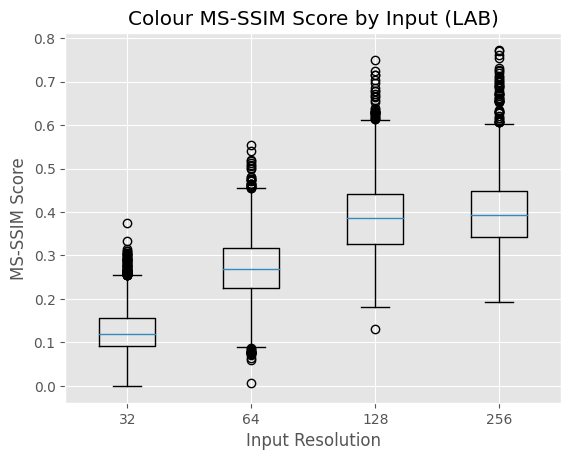

In [14]:
dim_labels = [32,64,128,256]
plt.style.use('ggplot')
plt.boxplot(np.transpose(color_output_diffs.numpy()),
            labels = dim_labels)
plt.ylabel("MS-SSIM Score")
plt.xlabel("Input Resolution")
plt.title("Colour MS-SSIM Score by Input (LAB)")

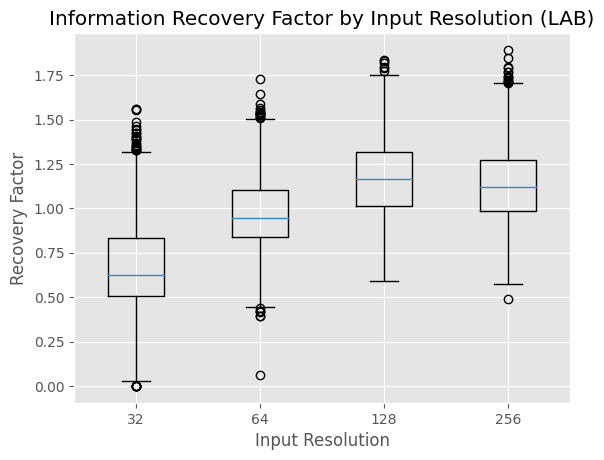

In [15]:
recovery_factor = torch.div(color_output_diffs, color_input_diffs)

plt.boxplot(np.transpose(recovery_factor.numpy()),
            labels = dim_labels)
plt.ylabel("Recovery Factor")
plt.xlabel("Input Resolution")
plt.title("Information Recovery Factor by Input Resolution (LAB)")

plt.show()

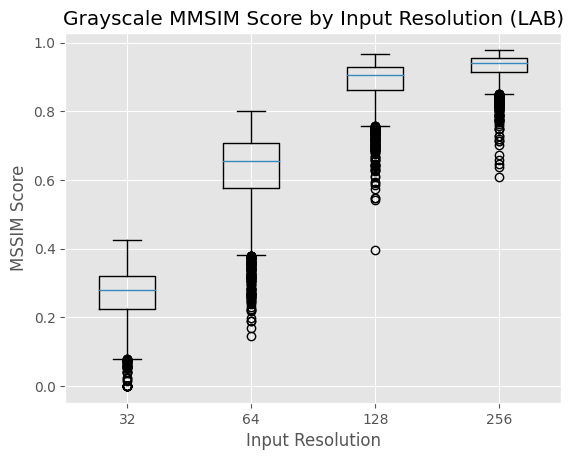

In [8]:
plt.boxplot(np.transpose(bw_output_diffs.numpy()),
            labels = dim_labels)
plt.ylabel("MSSIM Score")
plt.xlabel("Input Resolution")
plt.title("Grayscale MMSIM Score by Input Resolution (LAB)")

plt.show()

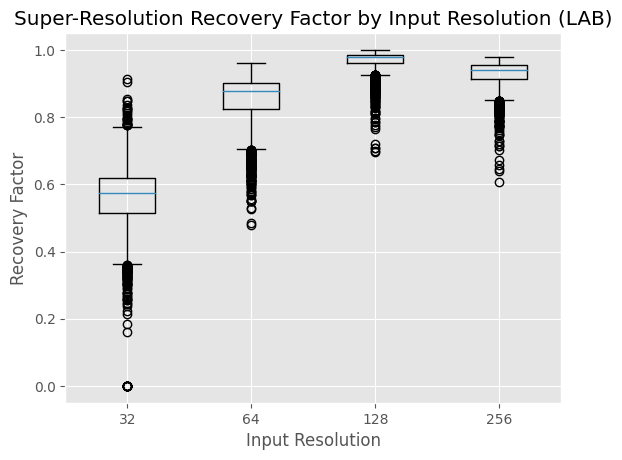

In [16]:
bw_recovery_factor = torch.div(bw_output_diffs, bw_input_diffs)

plt.boxplot(np.transpose(bw_recovery_factor.numpy()),
            labels = dim_labels)
plt.ylabel("Recovery Factor")
plt.xlabel("Input Resolution")
plt.title("Super-Resolution Recovery Factor by Input Resolution (LAB)")

plt.show()

# Comparison To Non-Transfer Learning Models

In [ ]:
ntl032 = Autoencoder('gray032')
ntl064 = Autoencoder('gray064')
ntl128 = Autoencoder('gray128')

#Paths to change
ntl032.encoder = torch.load('/content/CPSC-440-Project/models/LAB/notransfer_encoder_32',map_location=device)
ntl032.decoder = torch.load('/content/CPSC-440-Project/models/LAB/notransfer_decoder_32',map_location=device)

ntl064.encoder = torch.load('/content/CPSC-440-Project/models/LAB/notransfer_encoder_64',map_location=device)
ntl064.decoder = torch.load('/content/CPSC-440-Project/models/LAB/notransfer_decoder_64',map_location=device)

ntl128.encoder = torch.load('/content/CPSC-440-Project/models/LAB/notransfer_encoder_128',map_location=device)
ntl128.decoder = torch.load('/content/CPSC-440-Project/models/LAB/notransfer_decoder_128',map_location=device)

ntls = [ntl032, ntl064, ntl128]


In [ ]:
inputs = [gray032, gray064, gray128, gray256]
ntl_outputs = []

with torch.no_grad():
  for i in range(3):
    ntls[i].eval()
    ntls[i].to(device)
    ntl_output = []

    #Necessary due to GPU SIZE Restrictions on L4 (Maybe not A100?)
    ntl_output.append(ntls[i](inputs[i][:len(color)//2].to(device)).cpu())
    torch.cuda.empty_cache()

    ntl_output.append(ntls[i](inputs[i][len(color)//2:].to(device)).cpu())
    ntl_outputs.append(torch.cat(ntl_output))
    torch.cuda.empty_cache()

ntl_output = torch.stack(ntl_outputs)

In [ ]:
ntl_color_output_diffs = []   #Output to Target Similarity
ntl_bw_output_diffs = []      #De-colorized output to Grayscale Target Similarity

for i in range(3):
  ntl_color_output_diffs.append(ms_ssim(ntl_output[i], color, data_range = 1, size_average=False))

  ntl_bw_outputs = ntl_output[i][:, 0:1]
  ntl_bw_output_diffs.append(ms_ssim(ntl_bw_outputs, gray256, data_range = 1, size_average=False))

ntl_color_output_diffs = torch.stack(ntl_color_output_diffs)
ntl_bw_output_diffs = torch.stack(ntl_bw_output_diffs)

## Non-Transfer Learning Model Comparisons

torch.Size([6, 2400])


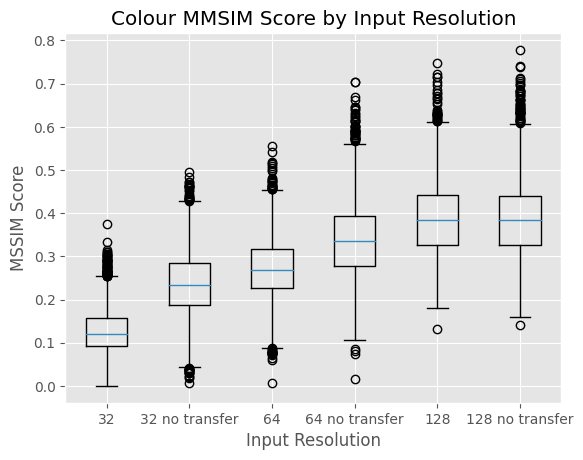

In [10]:
merged_scores = torch.stack((color_output_diffs[0:3], ntl_color_output_diffs), dim=1).view(6,2400)

print(merged_scores.shape)

plt.boxplot(np.transpose(merged_scores.numpy()),
            labels = [32, '32 no transfer', 64, '64 no transfer', 128, '128 no transfer'])
plt.ylabel("MSSIM Score")
plt.xlabel("Input Resolution")
plt.title("Colour MMSIM Score by Input Resolution")

plt.show()

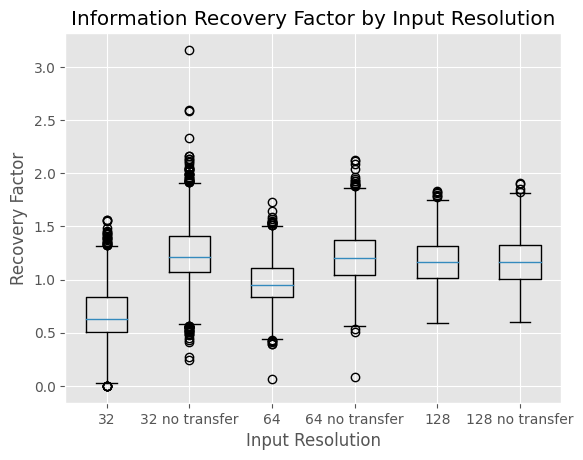

In [17]:
ntl_recovery_factor = torch.div(ntl_color_output_diffs, color_input_diffs[0:3])

merged_recovery_factor = torch.stack((recovery_factor[0:3], ntl_recovery_factor), dim=1).view(6,2400)

plt.boxplot(np.transpose(merged_recovery_factor.numpy()),
            labels = [32, '32 no transfer', 64, '64 no transfer', 128, '128 no transfer'])

plt.ylabel("Recovery Factor")
plt.xlabel("Input Resolution")
plt.title("Information Recovery Factor by Input Resolution")

plt.show()

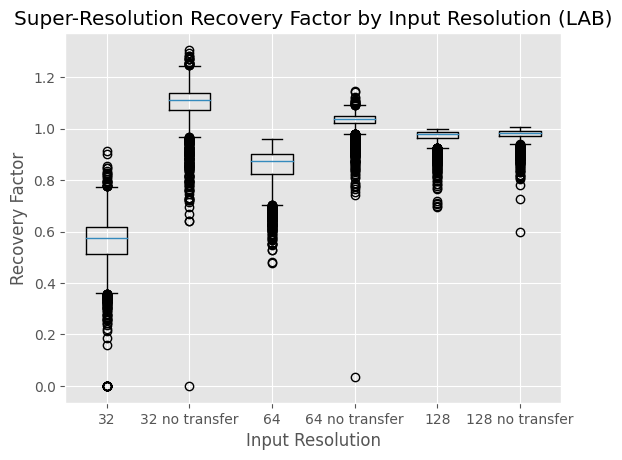

In [18]:
ntl_bw_recovery_factor = torch.div(ntl_bw_output_diffs, bw_input_diffs[0:3])

merged_bw_recovery_factor_scores =  torch.stack((bw_recovery_factor[0:3], ntl_bw_recovery_factor), dim=1).view(6,2400)

plt.boxplot(np.transpose(merged_bw_recovery_factor_scores.numpy()),
            labels = [32, '32 no transfer', 64, '64 no transfer', 128, '128 no transfer'])
plt.ylabel("Recovery Factor")
plt.xlabel("Input Resolution")
plt.title("Super-Resolution Recovery Factor by Input Resolution (LAB)")

plt.show()

In [ ]:
torch.save(ntl_color_output_diffs, '/content/CPSC-440-Project/models/LAB/mssim_scores/ntl_color_output_diffs')
torch.save(ntl_bw_output_diffs, '/content/CPSC-440-Project/models/LAB/mssim_scores/ntl_bw_output_diffs')

# Git

In [ ]:
%cd CPSC-440-Project/models/old models

/content/CPSC-440-Project/models/old models


In [ ]:
!git pull

remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 6 (delta 3), reused 6 (delta 3), pack-reused 0
Unpacking objects: 100% (6/6), 2.76 MiB | 5.01 MiB/s, done.
From https://github.com/StuartLiv/CPSC-440-Project
   4d5a31816..e9c8d57d6  main       -> origin/main
Updating 4d5a31816..e9c8d57d6
Fast-forward
 models/old models/notransfer_decoder_128 | Bin 1594126 -> 1594126 bytes
 models/old models/notransfer_encoder_128 | Bin 1535074 -> 1535074 bytes
 2 files changed, 0 insertions(+), 0 deletions(-)


In [ ]:
!git commit -m "updated mssim scores for non transfer learning models"

[main cd296949e] updated mssim scores for non transfer learning models
 2 files changed, 0 insertions(+), 0 deletions(-)
 rewrite models/old models/mssim_scores/ntl_bw_output_diffs (96%)
 rewrite models/old models/mssim_scores/ntl_color_output_diffs (96%)


In [ ]:
!git push

Enumerating objects: 12, done.
Counting objects: 100% (12/12), done.
Delta compression using up to 16 threads
Compressing objects: 100% (7/7), done.
Writing objects: 100% (7/7), 50.09 KiB | 12.52 MiB/s, done.
Total 7 (delta 4), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To https://github.com/StuartLiv/CPSC-440-Project
   773681299..cd296949e  main -> main
